In [15]:
import json
import os
import datetime
import boto3
import pickle
import numpy as np
import json    

with open('config-dev.json', 'r') as f:
    config = json.load(f)
    
import findspark
findspark.init(config['DEFAULT']['SPARK_HOME'])

from pyspark.sql import Row, SparkSession
from pyspark.ml.recommendation import ALS
from ml_training.utils import invert_mapping

class SparkRecommenderSystem():
    
    def __init__(self, config, mode='DEV'):
        self.config = config
        credentials = boto3.Session().get_credentials().get_frozen_credentials()
        self.aws_access_key_id = credentials.access_key
        self.aws_secret_access_key = credentials.secret_key
        self.aws_bucket_analytics = config[mode]['AWS_BUCKET_NAME']['ANALYTICS']
        self.aws_bucket_models = config[mode]['AWS_BUCKET_NAME']['MODELS']
        
    def create_spark_session(self):
        session = SparkSession.builder \
                            .config('spark.driver.memory', '4g') \
                            .config('spark.executor.cores', '4') \
                            .getOrCreate()
        
        session.sparkContext \
                ._jsc.hadoopConfiguration() \
                .set("fs.s3a.access.key", self.aws_access_key_id)
                
        session.sparkContext \
                ._jsc.hadoopConfiguration() \
                .set("fs.s3a.secret.key", self.aws_secret_access_key)

        return session
    
    @staticmethod
    def get_sale_id(event_properties: str) -> str:
        try:
            return json.loads(event_properties)['saleId']
        except:
            return ''
        
    def create_user_mapping(self, spark_df):
        self.model['user_mapping']['by_index'] = spark_df.select('user_id') \
            .distinct() \
            .toPandas()['user_id'] \
            .to_dict()
            
        self.model['user_mapping']['by_user'] = invert_mapping(self.model['user_mapping']['by_index'])
    
    def create_sale_mapping(self, spark_df):
        self.model['sale_mapping']['by_index'] = spark_df.select('event_properties') \
            .rdd \
            .map(lambda r: Row(sale_id=self.get_sale_id(r[0]))) \
            .toDF() \
            .distinct() \
            .toPandas()['sale_id'] \
            .to_dict()
        
        self.model['sale_mapping']['by_sale'] = invert_mapping(self.model['sale_mapping']['by_index'])
        
    def update_user_mapping(self, userFactors):
        self.model['user_mapping']['by_index'] = userFactors['id'] \
            .apply(lambda x : self.model['user_mapping']['by_index'][x]) \
            .to_dict()
        self.model['user_mapping']['by_user'] = invert_mapping(self.model['user_mapping']['by_index'])
        
    def update_sale_mapping(self, saleFactors):
        self.model['sale_mapping']['by_index'] = saleFactors['id'] \
            .apply(lambda x : self.model['sale_mapping']['by_index'][x]) \
            .to_dict()
        self.model['sale_mapping']['by_sale'] = invert_mapping(self.model['sale_mapping']['by_index'])
            
    def train_model(self):
        spark = self.create_spark_session()
        #df = spark.read.parquet('s3a://{}'.format(self.aws_bucket_analytics)).where("event_name = 'AddToCart'")
        df = spark.read.parquet('s3a://{}/201*'.format(self.aws_bucket_analytics)).where("event_name = 'AddToCart'")
            
        self.create_user_mapping(df)
        self.create_sale_mapping(df)
        
        self.ratings = df.select('event_name', 'event_properties', 'user_id') \
                        .rdd \
                        .map(lambda r: Row(user_id=self.model['user_mapping']['by_user'][r[2]],                                            
                                           sale_id=self.model['sale_mapping']['by_sale'][self.get_sale_id(r[1])],
                                           event=r[0])) \
                        .toDF() \
                        .groupby(['user_id', 'sale_id']) \
                        .count()
        
        (self.training, self.test) = self.ratings.randomSplit([0.8, 0.2])
        
    
        als = ALS(maxIter=10, 
                  regParam=0.1, 
                  implicitPrefs=True,
                  userCol="user_id", 
                  itemCol="sale_id", 
                  ratingCol="count", 
                  coldStartStrategy="drop")
        
        paramGrid = ParamGridBuilder() \
            .addGrid(als.rank, [2, 5]) \
            .build()
        
        evaluator = RegressionEvaluator(metricName="rmse", labelCol="count", predictionCol="prediction")
        
        crossval = CrossValidator(estimator=als,
                                  estimatorParamMaps=paramGrid,
                                  evaluator=evaluator,
                                  numFolds=2)
        
        model = crossval.fit(self.training)
        self.model['user_factors'] = np.array([row for row in model.userFactors.toPandas().features])
        self.model['sale_factors'] = np.array([row for row in model.itemFactors.toPandas().features])
        self.update_user_mapping(model.userFactors.toPandas())
        self.update_sale_mapping(model.itemFactors.toPandas())
        print(len(self.model['user_mapping']))
        
    def upload_model(self):
        date = datetime.datetime.now().strftime("%Y-%m-%d")
        model_path = 's3a://{}/sales/specialnew/{}'.format(self.aws_bucket_models, date)
        
        print("Saving the Spark model into pickled files...")
        
        client = boto3.client(
            's3',
            aws_access_key_id=self.aws_access_key_id,
            aws_secret_access_key=self.aws_secret_access_key
        )

        client.put_object(
            Body=pickle.dumps(self.model), 
            Bucket=self.aws_bucket_models, 
            Key='sales/specialnew/{}/recommender.pickle'.format(date)
        )

        client.put_object(
            Body=json.dumps({'version': date}), 
            Bucket=self.aws_bucket_models, 
            Key='sales/specialnew/version.json'.format(date)
        )        

In [16]:
reco = SparkRecommenderSystem(config)

In [17]:
spark = reco.create_spark_session()
df = spark.read.parquet('s3a://{}'.format(reco.aws_bucket_analytics))

In [18]:
reco.create_user_mapping(df)
reco.create_sale_mapping(df)
        
reco.ratings = df.select('event_name', 'event_properties', 'user_id') \
                        .rdd \
                        .map(lambda r: Row(user_id=reco.model['user_mapping']['by_user'][r[2]],                                            
                                           sale_id=reco.model['sale_mapping']['by_sale'][reco.get_sale_id(r[1])],
                                           event=r[0])) \
                        .toDF() \
                        .groupby(['user_id', 'sale_id']) \
                        .count()

In [23]:
len(reco.model['user_mapping']['by_index'])

9578

In [24]:
from pyspark.sql import Row
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator

In [25]:
(reco.training, reco.test) = reco.ratings.randomSplit([0.8, 0.2])
        
als = ALS(maxIter=10, regParam=0.1, 
          implicitPrefs=True,
          userCol="user_id", 
          itemCol="sale_id", 
          ratingCol="count", 
          coldStartStrategy="drop")

paramGrid = ParamGridBuilder() \
            .addGrid(als.rank, [2, 5]) \
            .build()
        
evaluator = RegressionEvaluator(metricName="rmse", labelCol="count", predictionCol="prediction")
        
crossval = CrossValidator(estimator=als,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=2)

In [26]:
model = crossval.fit(reco.training)

In [31]:
model.bestModel.userFactors.count()

9285

In [31]:
import json
from psycopg2 import connect
import pandas as pd
import numpy as np
import datetime
import pickle
import boto3

class ColdStartModel():

    def __init__(self, config, model, mode='DEV'):            
        self.host = config['POSTGRESQL']['HOST']
        self.database = config['POSTGRESQL']['DATABASE']
        self.user = config['POSTGRESQL']['USER']
        self.password = config['POSTGRESQL']['PASSWORD'] 
        self.aws_access_key_id = config[mode]['AWS_ACCESS_KEY_ID']
        self.aws_secret_access_key = config[mode]['AWS_SECRET_ACCESS_KEY']
        self.aws_bucket_analytics = config[mode]['AWS_BUCKET_NAME']['ANALYTICS']
        self.aws_bucket_models = config[mode]['AWS_BUCKET_NAME']['MODELS']
        
        self.fetch_data(model)

    def fetch_data(self, model):

        conn = connect(
            host=self.host, 
            database=self.database, 
            user=self.user, 
            password=self.password
        )
        
        sql_query = 'SELECT user_key, apps FROM users WHERE apps IS NOT NULL AND user_key IN {}'
        
        data = pd.io.sql.read_sql_query(
            sql_query.format(str(tuple(model.user_mapping[0]['by_index'].values()))), 
            conn
        )
        
        self.user_mapping = data['user_key'].to_dict()
        self.apps = pd.io.json.json_normalize(data['apps'])
        self.app_mapping = pd.DataFrame(self.apps.columns.values)[0].to_dict()
        self.__transform_user_factors()

    def __transform_user_factors(self):         
        # for each app, replace each missing value with the most frequent value 
        for app in self.apps.columns.values:
            self.apps[app].fillna(self.apps[app].mode()[0], inplace=True)
        # pd.DataFrame to np.array
        self.user_factors = (self.apps * 1).values    

In [14]:
from pyspark.mllib.evaluation import RegressionMetrics


In [14]:
RegressionMetrics()

SyntaxError: keyword can't be an expression (<ipython-input-14-bb1bdf05e65f>, line 2)

In [48]:
1.543104018835 * 1000000000

1543104018.835

In [14]:
obj.user_mapping[0]['by_index'].values()

dict_values(['pxMpKQ1SekMDj3EET5qPgWaSwrS2', 'Ah04UrBcgtWdw8yCKOfVzpGZ0OU2', 'HIEQ63JcLXgR2PAflapfmNyQsrD2', 'Wnb9HhfkzrQqAcHu0fW8N66nOPu2', 'dOFJWfik50Nzv83bTByzgaJITEJ2', 'ig93UaWJXhRz87yI3UNwKJhH7Ki1', '2m4EEY52VYfumD204W0QNf9MG7f2', 'RtDMI8N00fXNCU97KzIF7Unv5z73', '9mHnpeesrzNgLIbAuQQwyCOsFeD2', 'dbMGEhHe5pWfHhtNqqbDU9BfyHl1', 'j0JmnxN6dsY3uUMjsETVNEUqKxz1', 'YV2TvG3TvkMollVsO3R9opGXazi2', 'VWbp8gjTVHTpiE01lvoHEfIVEWo1', 'rQjBNGWagCeMXEtRvEwJ18yhiFR2', 'NgtYYZK46cZi1nbhDvmWD08xdXP2', 'NpkEct8qbhZHLZ8r815gs7pH9rl2', 'VakTxLCziVfCEQudM3pFVD7VUYY2', 'LaoCeN28vDb4hnNJJwUxG28yZl62', 'XwFbOvp47scjnzqLrfi0dFAcFNO2', 'EOi1tltc2VMUFt7mNyUNyGczb7o1', 'eblgkULY04fvCa8PuvYv5GA4tq13', 'GwPj6rqIeKbw3778vKBraYyE2AD2', '8b52XVOGHgXAYJUuuRFDRggBHDR2', 'GkxMVCu4FGXxGU49a15heOIHLEf1', 'EEM3ACeDasQT4SnH6PsO0Uguy6S2', 'AcoXij9ys7NP2X4GA7EDqjIBIfp2', 'JvxNX9mjbjXpWKzF8cv9K4VUhFe2', 'UFkrsssRqFZCx5adVR3X5cQD0Zt2', 'dQDRCK1gCwarQ7KVRH61b4uiUmG2', 'zNLbaOqcsxb9ercjgmohl6WD2Lq1', 'ctycuvz6bGOfFDES4WtrDFpDwg

In [125]:
reco.ratings.where("user_id = 10").show()

+-------+-------+-----+
|user_id|sale_id|count|
+-------+-------+-----+
|     10|     18|    2|
+-------+-------+-----+



In [50]:
df = spark.read.parquet('s3a://{}'.format(self.aws_bucket_analytics)).where("event_timeevent_name = 'AddToCart'")


id                                           features
0      0  [-0.28098148107528687, -0.000893049465958029, ...
1     10  [-0.21740612387657166, 0.21264034509658813, 0....
2     20  [-0.19124118983745575, -0.2040005624294281, 0....
3     30  [0.22868084907531738, 0.1996128112077713, 0.07...
4     40  [-0.21324345469474792, 0.20856893062591553, 0....
5     50  [-0.5088862776756287, 0.1797720193862915, 0.23...
6     60  [-0.08266108483076096, -0.2361740916967392, 0....
7     70  [-0.21740612387657166, 0.21264034509658813, 0....
8     80  [-0.14044080674648285, -0.2900511920452118, -0...
9     90  [0.012476048432290554, 0.2538759112358093, -0....
10   100  [0.006625978276133537, -0.3655147850513458, -0...
11   130  [0.16199104487895966, -0.09764394164085388, 0....
12   140  [-0.047917090356349945, -0.024762829765677452,...
13   150  [0.018053686246275902, -0.43686413764953613, 0...
14   160  [-0.18567761778831482, -0.31164661049842834, 0...
15   170  [-0.07844306528568268, -0.010929635725915432, ...
16   180  [-0.21740612387657166, 0.21264034509658813, 0....
17   200  [-0.5088862776756287, 0.1797720193862915, 0.23...
18   210  [-0.14974282681941986, 0.16759717464447021, -0...
19   220  [-0.07582883536815643, -0.21665340662002563, 0...
20   230  [-0.19664661586284637, 0.37118393182754517, 0....
21   240  [0.2889972925186157, -0.17419998347759247, 0.2...
22   270  [0.24419529736042023, 0.16818365454673767, -0....
23   280  [-0.16406895220279694, 0.09585115313529968, 0....
24   290  [-0.6794764995574951, 0.23170815408229828, -0....
25   300  [0.006625978276133537, -0.3655147850513458, -0...
26   310  [-0.21740612387657166, 0.21264034509658813, 0....
27   320  [0.2523362636566162, 0.17379054427146912, -0.0...
28   340  [-0.3185528516769409, 0.2557424306869507, 0.12...
29   350  [0.13615815341472626, -0.28564831614494324, 0....
..   ...                                                ...
692  469  [-0.30480626225471497, -0.042100612074136734, ...
693  489  [0.24419529736042023, 0.16818365454673767, -0....
694  499  [-0.21324345469474792, 0.20856893062591553, 0....
695  509  [-0.18567761778831482, -0.31164661049842834, 0...
696  519  [-0.21324345469474792, 0.20856893062591553, 0....
697  529  [-0.2922397255897522, 0.3502054512500763, 0.03...
698  539  [0.24956296384334564, 0.17188049852848053, -0....
699  549  [-0.5411493182182312, 0.19116944074630737, 0.2...
700  569  [-0.2828490436077118, -0.2808486521244049, -0....
701  579  [0.24419529736042023, 0.16818365454673767, -0....
702  589  [0.13072781264781952, -0.06042076274752617, -0...
703  599  [-0.08130813390016556, 0.060958463698625565, -...
704  609  [-0.21324345469474792, 0.20856893062591553, 0....
705  629  [-0.44694608449935913, -0.0488058440387249, -0...
706  639  [-0.2985789179801941, -0.26675114035606384, -0...
707  649  [-0.3040047883987427, -0.21596106886863708, 0....
708  659  [-0.16779929399490356, 0.2800849378108978, -0....
709  669  [0.006625978276133537, -0.3655147850513458, -0...
710  679  [0.06636829674243927, -0.05945270508527756, 0....
711  689  [-0.4096273183822632, 0.41939887404441833, -0....
712  699  [0.12974460422992706, -0.27219322323799133, 0....
713  729  [-0.21324345469474792, 0.20856893062591553, 0....
714  739  [-0.07582883536815643, -0.21665340662002563, 0...
715  759  [0.14819806814193726, -0.06849529594182968, -0...
716  779  [-0.0344727486371994, 0.4670781195163727, 0.00...
717  789  [-0.21740612387657166, 0.21264034509658813, 0....
718  799  [-0.21324345469474792, 0.20856893062591553, 0....
719  809  [-0.6911295652389526, 0.37587058544158936, 0.5...
720  819  [0.0017373899463564157, 0.3825894296169281, 0....
721  829  [-0.11110511422157288, 0.34098076820373535, -0...

[722 rows x 2 columns]

In [118]:
for i in reco.user_mapping.values():
    if i not in ids:
        print(i)

2
6
12
19
29
38
60
65
98
126
146
152
155
163
178
179
180
188
193
195
197
203
213
216
219
226
230
232
260
263
279
283
287
292
295
297
306
311
325
326
337
360
362
370
373
380
382
385
394
402
412
423
425
429
450
455
464
472
477
478
485
489
497
515
520
521
522
524
531
533
538
539
551
555
560
564
568
571
579
582
583
587
591
602
603
607
631
633
639
644
664
667
679
680
681
682
683
693
703
707
711
712
719
722
730
739
741
746
753
759
768
774
795
805
807
810
811
820
825
826
830


In [123]:
def update_user_mapping(self):
    embedded_users = self.model.userFactors.select('id').toPandas()['id'].to_list()
    for k, v in self.user_mapping.items():
          if v not in embedded_users:
                del self.user_mapping[k]

+-------+-------+-----+
|user_id|sale_id|count|
+-------+-------+-----+
|    449|     30|    1|
|     51|     18|    2|
|    769|     18|    2|
|    729|     18|    1|
|     68|     21|    1|
|    364|     30|    1|
|    199|     15|    1|
|    460|     15|    1|
|     95|     18|    1|
|    619|     16|    1|
|     49|      8|    1|
|    550|     21|    1|
|    233|     16|    1|
|    363|     18|    1|
|     15|     21|    1|
|    164|     17|    1|
|    723|     30|    1|
|     48|     14|    1|
|    422|      6|    1|
|    824|      2|    3|
+-------+-------+-----+
only showing top 20 rows



In [97]:
len(reco.user_mapping.values())

847

In [1]:
import json
import os
import shutil
import datetime
import boto3
import pickle
import numpy as np

import findspark
findspark.init('/home/keurcien/spark-2.4.0-bin-hadoop2.7')

import pyspark
from pyspark.sql import Row, SparkSession
from pyspark.ml.recommendation import ALS
from ml_training.utils import invert_mapping

class MatrixFactorizationModel():
    
    def __init__(self, user_factors, user_mapping, sale_factors, sale_mapping):

        self.user_factors = user_factors, 
        self.sale_factors = sale_factors
        self.user_mapping = {
            'by_index': user_mapping,
            'by_user': invert_mapping(user_mapping)
        },
        self.sale_mapping = {
            'by_index': sale_mapping,
            'by_sale': invert_mapping(sale_mapping)
        }
        

class SparkRecommenderSystem():
    
    def __init__(self, config, mode='DEV'):
        self.config = config
        self.aws_access_key_id = config[mode]['AWS_ACCESS_KEY_ID']
        self.aws_secret_access_key = config[mode]['AWS_SECRET_ACCESS_KEY']
        self.aws_bucket_analytics = config[mode]['AWS_BUCKET_NAME']['ANALYTICS']
        self.aws_bucket_models = config[mode]['AWS_BUCKET_NAME']['MODELS']
        
    def create_spark_session(self):
        session = SparkSession.builder \
                            .config('spark.driver.memory', '4g') \
                            .config('spark.executor.cores', '4') \
                            .getOrCreate()
        
        session.sparkContext._jsc.hadoopConfiguration().set("fs.s3a.access.key", self.aws_access_key_id)
        session.sparkContext._jsc.hadoopConfiguration().set("fs.s3a.secret.key", self.aws_secret_access_key)
        return session
    
    @staticmethod
    def get_sale_id(event_properties: str) -> str:
        try:
            return json.loads(event_properties)['saleId']
        except:
            return ''
        
    def create_user_mapping(self, spark_df):
        return invert_mapping(spark_df.select('user_id') \
                                        .distinct() \
                                        .toPandas()['user_id'] \
                                        .to_dict())
    
    def create_sale_mapping(self, spark_df):
         return invert_mapping(spark_df.select('event_name', 'event_properties') \
                                        .rdd \
                                        .map(lambda r: Row(sale_id=self.get_sale_id(r[1]))) \
                                        .toDF() \
                                        .distinct() \
                                        .toPandas()['sale_id'] \
                                        .to_dict())
        
    def update_user_mapping(self):
        tmp = invert_mapping(self.user_mapping)
        self.user_mapping = self.userFactors['id'].apply(lambda x : tmp[x]).to_dict()
        
    def update_sale_mapping(self):
        tmp = invert_mapping(self.sale_mapping)
        self.sale_mapping = self.saleFactors['id'].apply(lambda x : tmp[x]).to_dict()
            
    def train_model(self):
        
        spark = self.create_spark_session()
        
        df = spark.read.parquet('s3a://{}'.format(self.aws_bucket_analytics)).where("event_name = 'AddToCart'")
            
        self.user_mapping = self.create_user_mapping(df)
        self.sale_mapping = self.create_sale_mapping(df)
        
        self.ratings = df.select('event_name', 'event_properties', 'user_id') \
                        .rdd \
                        .map(lambda r: Row(user_id=self.user_mapping[r[2]],                                            
                                           sale_id=self.sale_mapping[self.get_sale_id(r[1])],
                                           event=r[0])) \
                        .toDF() \
                        .groupby(['user_id', 'sale_id']) \
                        .count()
        
        (self.training, self.test) = self.ratings.randomSplit([0.8, 0.2])
        
        als = ALS(maxIter=10, 
                  regParam=0.1, 
                  implicitPrefs=True,
                  userCol="user_id", 
                  itemCol="sale_id", 
                  ratingCol="count", 
                  coldStartStrategy="drop")
        
        model = als.fit(self.training)
        self.userFactors = model.userFactors.toPandas()
        self.saleFactors = model.itemFactors.toPandas()
        self.update_user_mapping()
        self.update_sale_mapping()
        
    def upload_model(self):
            
        date = datetime.datetime.now().strftime("%Y-%m-%d")
        model_path = 's3a://{}/sales/specialnew/{}'.format(self.aws_bucket_models, date)
        
        print("Saving the Spark model into pickled files...")
        
        model = MatrixFactorizationModel(
            user_factors=np.array([row for row in self.userFactors.features]),
            user_mapping=self.user_mapping,
            sale_factors=np.array([row for row in self.saleFactors.features]),
            sale_mapping=self.sale_mapping,
        )

        client = boto3.client(
            's3',
            aws_access_key_id=self.aws_access_key_id,
            aws_secret_access_key=self.aws_secret_access_key
        )

        client.put_object(
            Body=pickle.dumps(model), 
            Bucket=self.aws_bucket_models, 
            Key='sales/specialnew/{}/test.pickle'.format(date)
        )

        client.put_object(
            Body=json.dumps({'version': date}), 
            Bucket=self.aws_bucket_models, 
            Key='sales/specialnew/version.json'.format(date)
        )        

In [32]:
import json    

with open('config-prod.json', 'r') as f:
    config = json.load(f)
    
reco = SparkRecommenderSystem(config)

In [6]:
reco.train_model()

{'user_factors': None,
 'user_mapping': {'by_index': None, 'by_user': None},
 'sale_factors': None,
 'sale_mapping': {'by_index': None, 'by_sale': None}}

In [33]:
client = boto3.client(
    's3',
    aws_access_key_id=reco.aws_access_key_id,
    aws_secret_access_key=reco.aws_secret_access_key
)

import datetime
date = datetime.datetime.now().strftime("%Y-%m-%d")

In [34]:
import io
import pickle

def get_from_s3(client, bucket, key):

    response = client.get_object(Bucket=bucket, Key=key)

    with io.BytesIO(response['Body'].read()) as f:
        f.seek(0)  # rewind the file
        return pickle.load(f)

In [195]:
obj = get_from_s3(client, bucket=reco.aws_bucket_models, key='sales/specialnew/{}/recommender.pickle'.format('2019-02-19'))

In [196]:
len(obj['user_mapping']['by_index'])

9311

In [212]:
user_features = obj['user_factors']

In [214]:
from matplotlib.pyplot import plot

plot(user_features[:,0], user_features[:,1], 'o')

In [149]:
import numpy as np
obj['user_mapping']['by_index'][38058]

'heMmrilxGUYy9Ue2eEXCLRHaZnu1'

In [199]:
user_features.shape

(115, 20)

In [215]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
pca = PCA(n_components=6)
res = StandardScaler().fit_transform(user_features)
principalComponents = pca.fit_transform(res)

In [216]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

plot(principalComponents[:,0], principalComponents[:,1], "o")

/home/keurcien/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


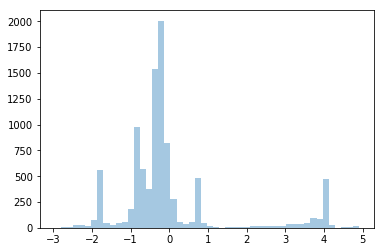

In [217]:
sns.distplot(principalComponents[:,0], kde=False)

In [218]:
np.where(principalComponents[:,0] < -1)

(array([   9,   29,   31,   32,   50,   57,   69,  102,  105,  125,  134,
         137,  147,  148,  168,  189,  191,  195,  208,  216,  222,  225,
         234,  239,  248,  261,  271,  272,  276,  287,  292,  315,  323,
         329,  345,  360,  380,  396,  419,  422,  441,  468,  469,  478,
         493,  505,  522,  529,  532,  535,  538,  539,  543,  548,  552,
         553,  566,  583,  593,  599,  603,  659,  669,  675,  677,  687,
         695,  698,  709,  714,  722,  734,  739,  746,  775,  779,  802,
         825,  834,  839,  841,  857,  869,  872,  875,  881,  883,  891,
         903,  912,  924,  935,  936,  946,  956,  959,  969,  981,  984,
         986,  995, 1023, 1036, 1082, 1084, 1105, 1116, 1122, 1123, 1126,
        1134, 1138, 1139, 1144, 1165, 1181, 1186, 1191, 1195, 1216, 1219,
        1221, 1250, 1253, 1261, 1265, 1270, 1274, 1324, 1334, 1339, 1341,
        1353, 1356, 1369, 1388, 1390, 1394, 1402, 1412, 1421, 1425, 1430,
        1439, 1440, 1444, 1445, 1447, 

In [219]:
obj['user_mapping']['by_index'][29]

'jZXdAlIkmQbX6KSWrrcft07nAXB3'

In [223]:
from sklearn.cluster import KMeans

#Set a 3 KMeans clustering
kmeans = KMeans(n_clusters = 5)

m = principalComponents[:,0:2]

#Compute cluster centers and predict cluster indices
X_clustered = kmeans.fit_predict(m)

#Define our own color map
LABEL_COLOR_MAP = {0:'r', 1: 'g', 2: 'b', 3: 'y', 4: 'm', 5: 'k'}
label_color = [LABEL_COLOR_MAP[l] for l in X_clustered]

# Plot the scatter digram
plt.figure(figsize = (7,7))
plt.scatter(m[:,0],m[:,1], c= label_color, alpha=0.5) 
plt.show()

In [276]:
pd.DataFrame({'id': [x for x in obj['user_mapping']['by_index'].values()],
              'cluster': label_color}).to_csv("cluster.csv")

In [224]:
import pandas as pd
d = pd.read_csv("../sales.csv")

d = d.set_index('id').to_dict()['name']

In [226]:
for x in np.where((principalComponents[:,0] < 0) * principalComponents[:,1] > 0)[0]:
    print(d[obj['sale_mapping']['by_index'][x]]) 

Blash
Dream One Studio
Polaroid
Benamor
Zhed
Thé & Beauté by Ladurée
Holi
Aëdle
Emma & Chloé
Yumaki
Björn
Unrefined
Oh My Tea !
South Lane


KeyError: 117

In [210]:
for x in np.where((principalComponents[:,0] > 1) * (principalComponents[:,1] < 1))[0]:
    print(d[obj['sale_mapping']['by_index'][x]])

Blash
Dream One Studio
Not Your Girl
Emma & Chloé
Zede
Vain Sthlm
Design Letters
SachaJuan
Païpite
Roark


In [252]:
principalComponents

array([[-0.54304017, -0.46040303, -0.07619244, -0.32227406,  0.15855157,
         0.00826432],
       [ 4.00449215,  1.45083303, -0.34673565, -0.44752234, -0.02661209,
         0.00658922],
       [-0.99235009, -0.23022709, -0.3003639 ,  0.36270867,  0.21171929,
        -0.37193795],
       ...,
       [ 0.8116032 , -2.68712044,  3.40826257,  1.10024103, -0.08421887,
         0.49633309],
       [-0.1899452 , -0.19869957, -0.18868837, -0.09705563,  0.0493122 ,
        -0.02669351],
       [-0.34078948,  0.06583545, -1.95273019,  4.05982159, -0.18829382,
         0.24548724]])

In [237]:
with open('config-dev.json', 'r') as f:
    config = json.load(f)
    
import findspark
findspark.init(config['DEFAULT']['SPARK_HOME'])
import pyspark

class ParquetReader():
    
    def __init__(self, config):
        self.aws_access_key_id = config['AWS']['AWS_ACCESS_KEY_ID']
        self.aws_secret_access_key = config['AWS']['AWS_SECRET_ACCESS_KEY']
        self.aws_bucket_analytics = config['AWS']['AWS_BUCKET_NAME']['ANALYTICS']

    def create_spark_session(self):
        session = SparkSession.builder \
                            .config('spark.driver.memory', '4g') \
                            .config('spark.executor.cores', '4') \
                            .getOrCreate()
        
        session.sparkContext \
                ._jsc.hadoopConfiguration() \
                .set("fs.s3a.access.key", self.aws_access_key_id)
                
        session.sparkContext \
                ._jsc.hadoopConfiguration() \
                .set("fs.s3a.secret.key", self.aws_secret_access_key)

        return session
    
    def sql(self, condition="event_name = 'AddToCart'"):
        sess = self.create_spark_session()
        df = sess.read.parquet('s3a://{}/201*'.format(parquet_reader.aws_bucket_analytics)) \
                      .where(condition)
        return df

In [238]:
parquet_reader = ParquetReader(config=config)

In [250]:
df = parquet_reader.sql().select('event_name', 'user_id', 'event_properties').toPandas()

In [279]:
df['sale_id'] = df['event_properties'].apply(lambda x: d[json.loads(x)['saleId']])

In [282]:
df['item_category'] = df['event_properties'].apply(lambda x: json.loads(x)['category'])

In [284]:
df['event_properties'][0]

'{"itemId":"e3481f0fe2bc4e3ea37d833e5","triggerStock":false,"stock":null,"brandId":"159887893fcc4a0d8cabf0fdc","saleId":"140b2ff7a6b64908996b26f23","listPrice":25,"netPrice":15,"discountAmount":10,"discountRate":0.4,"category":"beauty","profile":"unisex","from":"PageItem"}'

In [ ]:
df['discountAmount'] = df['event_properties'].apply(lambda x: json.loads(x)['discountAmount'])
df['discountAmount'] = df['event_properties'].apply(lambda x: json.loads(x)['discountAmount'])

In [289]:
df['discountRate'] = df['event_properties'].apply(lambda x: json.loads(x)['discountRate'])

In [298]:
df['profile'] = df['event_properties'].apply(lambda x: json.loads(x)['profile'])

In [314]:
def assign_cluster(i):
    try:
        cluster[i]
    except:
        None

df['cluster'] = df['user_id'].apply(lambda x: assign_cluster(x))

In [310]:
cluster = pd.read_csv("cluster.csv")[['id','cluster']].set_index('id').to_dict()['cluster']

In [315]:
df

event_name                       user_id  \
0     AddToCart  XZX0sRcRLJbZDiBj1i6W5fmztnF3   
1     AddToCart  6UakbNyH5Gbd8fqTOuWXSNiU4s23   
2     AddToCart  xHw5A7NImAWXqjBY5kGVJIiI8C03   
3     AddToCart  ZsdFyTugIhNsSNLJ7hBRNSVM84j2   
4     AddToCart  X9nJ8UJ4PGgk5ifMmsbBiQwFRui2   
5     AddToCart  X9nJ8UJ4PGgk5ifMmsbBiQwFRui2   
6     AddToCart  X9nJ8UJ4PGgk5ifMmsbBiQwFRui2   
7     AddToCart  X9nJ8UJ4PGgk5ifMmsbBiQwFRui2   
8     AddToCart  K0ZXP8K7eYehS4ZUA9AyIXe6ycE2   
9     AddToCart  6mqSgi61x7hCaijebDfNzIfXcun2   
10    AddToCart  2P5BvT824XUbLC6e5V3RBlJET273   
11    AddToCart  tQLvSFGdcOd3MXz5GJJLB6uL69l1   
12    AddToCart  iLDgxbQLPbgIbFAzeTtHYWFwuRD3   
13    AddToCart  nhyjWK7H2IWMbzSm9efTTa0OrY82   
14    AddToCart  nhyjWK7H2IWMbzSm9efTTa0OrY82   
15    AddToCart  sA1KZJ0TB6SBnGf3gmFUdvSJYZi2   
16    AddToCart  TYZ60XVZYUPRa7rKvE5PvzRNXUg2   
17    AddToCart  EM3mzuHKG5fjTtmQ7VAHG0QtPOi1   
18    AddToCart  Ck9e5gu1pZTUIXwTVEGOvwAqfYj1   
19    AddToCart  WXCcU0shRNasNzfMtxut4wz9dQh2   
20    AddToCart  QYBEVRzzorb9Dg3VTZg6bIcfNTL2   
21    AddToCart  QYBEVRzzorb9Dg3VTZg6bIcfNTL2   
22    AddToCart  QYBEVRzzorb9Dg3VTZg6bIcfNTL2   
23    AddToCart  tTYizf5i5xajNli2kWWD4eVwXPC2   
24    AddToCart  QYBEVRzzorb9Dg3VTZg6bIcfNTL2   
25    AddToCart  tTYizf5i5xajNli2kWWD4eVwXPC2   
26    AddToCart  ZxHfLrStAQaO2DhEW30HCDMO6tU2   
27    AddToCart  MebBcYfodZQgXbC8pqbmxBo3M8V2   
28    AddToCart  nhyjWK7H2IWMbzSm9efTTa0OrY82   
29    AddToCart  ojNxfCVRNePYv2l6yIVl1V4RALx2   
...         ...                           ...   
1858  AddToCart  JX8fQfWylFVEnEESDgzb95bfLQu2   
1859  AddToCart  AWSnWkgKHQM4BVPrUWjJp9qhdBx2   
1860  AddToCart  AWSnWkgKHQM4BVPrUWjJp9qhdBx2   
1861  AddToCart  AWSnWkgKHQM4BVPrUWjJp9qhdBx2   
1862  AddToCart  AWSnWkgKHQM4BVPrUWjJp9qhdBx2   
1863  AddToCart  AWSnWkgKHQM4BVPrUWjJp9qhdBx2   
1864  AddToCart  AWSnWkgKHQM4BVPrUWjJp9qhdBx2   
1865  AddToCart  AWSnWkgKHQM4BVPrUWjJp9qhdBx2   
1866  AddToCart  AWSnWkgKHQM4BVPrUWjJp9qhdBx2   
1867  AddToCart  AWSnWkgKHQM4BVPrUWjJp9qhdBx2   
1868  AddToCart  AWSnWkgKHQM4BVPrUWjJp9qhdBx2   
1869  AddToCart  AWSnWkgKHQM4BVPrUWjJp9qhdBx2   
1870  AddToCart  AWSnWkgKHQM4BVPrUWjJp9qhdBx2   
1871  AddToCart  AWSnWkgKHQM4BVPrUWjJp9qhdBx2   
1872  AddToCart  AWSnWkgKHQM4BVPrUWjJp9qhdBx2   
1873  AddToCart  8a5J5ChSmUVuqXbrHr7IrD3skTP2   
1874  AddToCart  8a5J5ChSmUVuqXbrHr7IrD3skTP2   
1875  AddToCart  8a5J5ChSmUVuqXbrHr7IrD3skTP2   
1876  AddToCart  8a5J5ChSmUVuqXbrHr7IrD3skTP2   
1877  AddToCart  fYktgqDrFtcMKWlxfdLpaNJh1vv2   
1878  AddToCart  fYktgqDrFtcMKWlxfdLpaNJh1vv2   
1879  AddToCart  wlReyfA0BvYryGCDBEOn9nDT0fV2   
1880  AddToCart  fYktgqDrFtcMKWlxfdLpaNJh1vv2   
1881  AddToCart  fYktgqDrFtcMKWlxfdLpaNJh1vv2   
1882  AddToCart  fYktgqDrFtcMKWlxfdLpaNJh1vv2   
1883  AddToCart  AWSnWkgKHQM4BVPrUWjJp9qhdBx2   
1884  AddToCart  AWSnWkgKHQM4BVPrUWjJp9qhdBx2   
1885  AddToCart  3Z15iKlppHPlisBZtiNnbL6mQvE2   
1886  AddToCart  Q0X732w95ocAx0h8AqbpBKUlHkU2   
1887  AddToCart  Q0X732w95ocAx0h8AqbpBKUlHkU2   

                                       event_properties              sale_id  \
0     {"itemId":"e3481f0fe2bc4e3ea37d833e5","trigger...        Planète Panda   
1     {"itemId":"32d9ae1077394ccc8a163c210","trigger...         L'intervalle   
2     {"itemId":"2e0e361b29644727b29957f06","trigger...  L'Affiche Technique   
3     {"itemId":"0deed083840047728034843ea","trigger...               Angèle   
4     {"itemId":"1fcc704dfbee47feb754fd783","trigger...               Fisura   
5     {"itemId":"e87200a77948426e80220bd9f","trigger...  L'Affiche Technique   
6     {"itemId":"7908eed22e2f4cac978709845","trigger...  L'Affiche Technique   
7     {"itemId":"14f8e12a79e24bd48a31f4941","trigger...                Blash   
8     {"itemId":"609617bc61fc4f4cbc2625d78","trigger...               OPAARK   
9     {"itemId":"c0a6ef0660724ed3946eac463","trigger...        Planète Panda   
10    {"itemId":"f1324a3b9d7f44f2b05caca30","trigger...        Planète Panda   
11    

In [319]:
df['coco'] = 0

In [320]:
df

event_name                       user_id  \
0     AddToCart  XZX0sRcRLJbZDiBj1i6W5fmztnF3   
1     AddToCart  6UakbNyH5Gbd8fqTOuWXSNiU4s23   
2     AddToCart  xHw5A7NImAWXqjBY5kGVJIiI8C03   
3     AddToCart  ZsdFyTugIhNsSNLJ7hBRNSVM84j2   
4     AddToCart  X9nJ8UJ4PGgk5ifMmsbBiQwFRui2   
5     AddToCart  X9nJ8UJ4PGgk5ifMmsbBiQwFRui2   
6     AddToCart  X9nJ8UJ4PGgk5ifMmsbBiQwFRui2   
7     AddToCart  X9nJ8UJ4PGgk5ifMmsbBiQwFRui2   
8     AddToCart  K0ZXP8K7eYehS4ZUA9AyIXe6ycE2   
9     AddToCart  6mqSgi61x7hCaijebDfNzIfXcun2   
10    AddToCart  2P5BvT824XUbLC6e5V3RBlJET273   
11    AddToCart  tQLvSFGdcOd3MXz5GJJLB6uL69l1   
12    AddToCart  iLDgxbQLPbgIbFAzeTtHYWFwuRD3   
13    AddToCart  nhyjWK7H2IWMbzSm9efTTa0OrY82   
14    AddToCart  nhyjWK7H2IWMbzSm9efTTa0OrY82   
15    AddToCart  sA1KZJ0TB6SBnGf3gmFUdvSJYZi2   
16    AddToCart  TYZ60XVZYUPRa7rKvE5PvzRNXUg2   
17    AddToCart  EM3mzuHKG5fjTtmQ7VAHG0QtPOi1   
18    AddToCart  Ck9e5gu1pZTUIXwTVEGOvwAqfYj1   
19    AddToCart  WXCcU0shRNasNzfMtxut4wz9dQh2   
20    AddToCart  QYBEVRzzorb9Dg3VTZg6bIcfNTL2   
21    AddToCart  QYBEVRzzorb9Dg3VTZg6bIcfNTL2   
22    AddToCart  QYBEVRzzorb9Dg3VTZg6bIcfNTL2   
23    AddToCart  tTYizf5i5xajNli2kWWD4eVwXPC2   
24    AddToCart  QYBEVRzzorb9Dg3VTZg6bIcfNTL2   
25    AddToCart  tTYizf5i5xajNli2kWWD4eVwXPC2   
26    AddToCart  ZxHfLrStAQaO2DhEW30HCDMO6tU2   
27    AddToCart  MebBcYfodZQgXbC8pqbmxBo3M8V2   
28    AddToCart  nhyjWK7H2IWMbzSm9efTTa0OrY82   
29    AddToCart  ojNxfCVRNePYv2l6yIVl1V4RALx2   
...         ...                           ...   
1858  AddToCart  JX8fQfWylFVEnEESDgzb95bfLQu2   
1859  AddToCart  AWSnWkgKHQM4BVPrUWjJp9qhdBx2   
1860  AddToCart  AWSnWkgKHQM4BVPrUWjJp9qhdBx2   
1861  AddToCart  AWSnWkgKHQM4BVPrUWjJp9qhdBx2   
1862  AddToCart  AWSnWkgKHQM4BVPrUWjJp9qhdBx2   
1863  AddToCart  AWSnWkgKHQM4BVPrUWjJp9qhdBx2   
1864  AddToCart  AWSnWkgKHQM4BVPrUWjJp9qhdBx2   
1865  AddToCart  AWSnWkgKHQM4BVPrUWjJp9qhdBx2   
1866  AddToCart  AWSnWkgKHQM4BVPrUWjJp9qhdBx2   
1867  AddToCart  AWSnWkgKHQM4BVPrUWjJp9qhdBx2   
1868  AddToCart  AWSnWkgKHQM4BVPrUWjJp9qhdBx2   
1869  AddToCart  AWSnWkgKHQM4BVPrUWjJp9qhdBx2   
1870  AddToCart  AWSnWkgKHQM4BVPrUWjJp9qhdBx2   
1871  AddToCart  AWSnWkgKHQM4BVPrUWjJp9qhdBx2   
1872  AddToCart  AWSnWkgKHQM4BVPrUWjJp9qhdBx2   
1873  AddToCart  8a5J5ChSmUVuqXbrHr7IrD3skTP2   
1874  AddToCart  8a5J5ChSmUVuqXbrHr7IrD3skTP2   
1875  AddToCart  8a5J5ChSmUVuqXbrHr7IrD3skTP2   
1876  AddToCart  8a5J5ChSmUVuqXbrHr7IrD3skTP2   
1877  AddToCart  fYktgqDrFtcMKWlxfdLpaNJh1vv2   
1878  AddToCart  fYktgqDrFtcMKWlxfdLpaNJh1vv2   
1879  AddToCart  wlReyfA0BvYryGCDBEOn9nDT0fV2   
1880  AddToCart  fYktgqDrFtcMKWlxfdLpaNJh1vv2   
1881  AddToCart  fYktgqDrFtcMKWlxfdLpaNJh1vv2   
1882  AddToCart  fYktgqDrFtcMKWlxfdLpaNJh1vv2   
1883  AddToCart  AWSnWkgKHQM4BVPrUWjJp9qhdBx2   
1884  AddToCart  AWSnWkgKHQM4BVPrUWjJp9qhdBx2   
1885  AddToCart  3Z15iKlppHPlisBZtiNnbL6mQvE2   
1886  AddToCart  Q0X732w95ocAx0h8AqbpBKUlHkU2   
1887  AddToCart  Q0X732w95ocAx0h8AqbpBKUlHkU2   

                                       event_properties              sale_id  \
0     {"itemId":"e3481f0fe2bc4e3ea37d833e5","trigger...        Planète Panda   
1     {"itemId":"32d9ae1077394ccc8a163c210","trigger...         L'intervalle   
2     {"itemId":"2e0e361b29644727b29957f06","trigger...  L'Affiche Technique   
3     {"itemId":"0deed083840047728034843ea","trigger...               Angèle   
4     {"itemId":"1fcc704dfbee47feb754fd783","trigger...               Fisura   
5     {"itemId":"e87200a77948426e80220bd9f","trigger...  L'Affiche Technique   
6     {"itemId":"7908eed22e2f4cac978709845","trigger...  L'Affiche Technique   
7     {"itemId":"14f8e12a79e24bd48a31f4941","trigger...                Blash   
8     {"itemId":"609617bc61fc4f4cbc2625d78","trigger...               OPAARK   
9     {"itemId":"c0a6ef0660724ed3946eac463","trigger...        Planète Panda   
10    {"itemId":"f1324a3b9d7f44f2b05caca30","trigger...        Planète Panda   
11    